## How much does it matter who labelled the dataset? 

This is largely inspired by the [Are We Modeling the Task or the Annotator?](https://aclanthology.org/D19-1107.pdf) paper.

In [1]:
import pandas as pd

In [2]:
df = pd.concat([pd.read_csv(f"data/full_dataset/goemotions_{i}.csv") for i in [1, 2, 3]])

In [3]:
df.columns

Index(['text', 'id', 'author', 'subreddit', 'link_id', 'parent_id',
       'created_utc', 'rater_id', 'example_very_unclear', 'admiration',
       'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion',
       'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust',
       'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy',
       'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief',
       'remorse', 'sadness', 'surprise', 'neutral'],
      dtype='object')

<AxesSubplot:title={'center':'rater distribution'}>

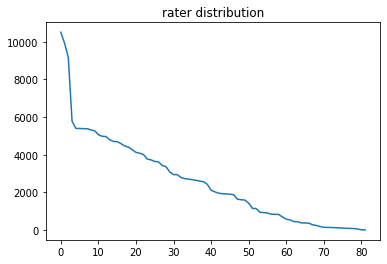

In [4]:
df['rater_id'].value_counts().reset_index()['rater_id'].plot(title="rater distribution")

In [5]:
COLUM_OF_INTEREST = "anger"

In [6]:
df[['id']].nunique() * 0.05

id    2900.55
dtype: float64

In [7]:
summary = (df
 .groupby('rater_id')
 .agg(count=("id", "nunique"), pref=(COLUM_OF_INTEREST, "mean"))
 .sort_values("pref")
 .loc[lambda d: d['count'] > 5000])

summary

,count,pref
rater_id,,
15,5064,0.011058
60,5318,0.018240
24,5383,0.020063
61,9930,0.034945
62,5380,0.035502
4,10508,0.046155
81,5271,0.046860
37,9161,0.051086
2,5778,0.054171


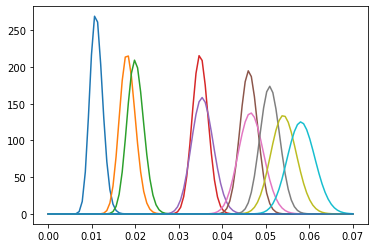

In [8]:
import numpy as np
from scipy.stats import beta
import matplotlib.pylab as plt

xs = np.linspace(0, 0.07, 100)

for row in summary.to_dict(orient="records"):
    n_hit = int(row['count'] * row['pref'])
    plt.plot(xs, beta(n_hit, row['count'] - n_hit).pdf(xs))

In [9]:
rater_ids = df.groupby('rater_id').agg(count=("id", "nunique")).reset_index().loc[lambda d: d['count'] > 4000]['rater_id'].values

In [10]:
subset = (df
          [['text', 'id', COLUM_OF_INTEREST, 'rater_id', 'example_very_unclear']]
          .loc[lambda d: d['rater_id'].isin(rater_ids)])

In [11]:
corvals = subset[['id', 'rater_id', COLUM_OF_INTEREST]].pivot(index="id", columns="rater_id", values=COLUM_OF_INTEREST).corr().values

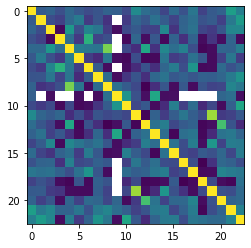

In [12]:
import matplotlib.pylab as plt

plt.imshow(corvals)

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(subset[['text', 'rater_id', COLUM_OF_INTEREST]], subset[COLUM_OF_INTEREST].values, stratify=subset['rater_id'])

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, make_union, Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer

In [15]:
from typing import List
from sklearn.base import BaseEstimator, TransformerMixin


class ColumnLister(BaseEstimator, TransformerMixin):
    """Takes a pandas column as a list of text."""

    def __init__(self, column) -> None:
        self.column = column

    def fit(self, X, y) -> "ColumnLister":
        """Fits the estimator. No-op."""
        return self

    def transform(self, X) -> List[str]:
        """Transforms the data per scikit-learn API."""
        return X[self.column].to_list()

    def fit_transform(self, X, y=None, **fit_params) -> List[str]:
        """Transforms the data per scikit-learn API."""
        return self.fit(X, y).transform(X)

In [16]:
pipe = make_pipeline(
    ColumnLister("text"), 
    CountVectorizer(), 
    LogisticRegression(max_iter=500, class_weight="balanced")
)
pipe.fit(X_train, y_train)

Pipeline(steps=[('columnlister', ColumnLister(column='text')),
                ('countvectorizer', CountVectorizer()),
                ('logisticregression',
                 LogisticRegression(class_weight='balanced', max_iter=500))])

In [17]:
from sklearn.metrics import classification_report

print(classification_report(pipe.predict(X_test), y_test))

              precision    recall  f1-score   support

           0       0.91      0.98      0.94     28151
           1       0.59      0.21      0.31      3510

    accuracy                           0.90     31661
   macro avg       0.75      0.59      0.63     31661
weighted avg       0.87      0.90      0.87     31661



In [18]:
import tqdm 

models = {}

for rater, data in tqdm.tqdm(X_train.groupby("rater_id")):
    pipe_temp_ = make_pipeline(
        ColumnLister("text"), 
        CountVectorizer(), 
        LogisticRegression(max_iter=500, class_weight="balanced")
    )
    models[rater] = pipe_temp_.fit(data[['text']], data[COLUM_OF_INTEREST])

100%|████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.18it/s]


In [19]:
pred, actual = [], [] 

for rater, data in tqdm.tqdm(X_test.groupby("rater_id")):
    y_actual = data[COLUM_OF_INTEREST]
    y_pred = models[rater].predict(data)
    actual = actual + list(y_actual)
    pred = pred + list(y_pred)

100%|████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 87.05it/s]


In [20]:
print(classification_report(pred, actual))

              precision    recall  f1-score   support

           0       0.97      0.97      0.97     30256
           1       0.36      0.32      0.34      1405

    accuracy                           0.95     31661
   macro avg       0.67      0.65      0.66     31661
weighted avg       0.94      0.95      0.94     31661

